In [1]:
import pykep as pk
import numpy as np
import json
import pickle as pkl

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

# We import the dataset containing the info on the tracked population
The files needed are:
* satcat.txt (from https://celestrak.com/satcat/search.php) - This contains, for some, the RCS in meters.
* satcat_json (from https://www.space-track.org/basicspacedata/query/class/gp/decay_date/null-val/epoch/%3Enow-30/orderby/norad_cat_id/format/json) -This has all information, but the RCS that only carries three levels small, medium big.


In [2]:
# Import the "old" SATCAT
satcat_old = pk.util.read_satcat("data/satcat.txt")
# Import the json catalogue
with open("data/satcat.json", "r") as file:
    satcat = json.load(file)
print("Satellites number in json: ", len(satcat))
print("Satellites number in txt: ", len(satcat_old))

Satellites number in json:  23947
Satellites number in txt:  51407


The txt (SATCAT) contains more entries as all past decayed objects are also present, while in the json we only hve the currently orbiting ones

In [3]:
# Lets build the various orbiting objects from the TLEs
debris = []
for entry in satcat:
    try:
        line1 = entry["TLE_LINE1"]
        line2 = entry["TLE_LINE2"]
        debris.append(pk.planet.tle(line1, line2))
    except RuntimeError:
        # The alpha-5 format (https://www.space-track.org/documentation#tle-alpha5) is accounted for (ignored)
        # here. 
        line1 = list(line1)
        line1[2] = '0'
        line1 = ''.join(line1)
        line2 = list(line2)
        line2[2] = '0'
        line2 = ''.join(line2)
        debris.append(pk.planet.tle(line1, line2))

print("Satellites number with valid TLEs:", len(debris))

Satellites number with valid TLEs: 23947


In [4]:
# For each debris we retrieve and monkey patch the planet class with its collision radius
for deb, deb_data in zip(debris, satcat):
    key = deb.name.strip()
    if key in satcat_old and satcat_old[key].radarA.strip() != "N/A":
        radius = np.sqrt(float(satcat_old[key].radarA)/np.pi)
    else:
        if deb_data["RCS_SIZE"] == "SMALL":
            radius = 0.15
        elif deb_data["RCS_SIZE"] == "MEDIUM":
            radius = 0.55
        else:
            radius = 2.
    deb.collision_radius = radius

In [5]:
# We create the initial state for all satellites that are not decayed and filtered
r = []
v = []
smal = []
el = []
incl = []
reentry_radiusl= []
to_satcat_index = []
n_decayed = 0
t0 = pk.epoch_from_iso_string("20220301T000000")
for j, deb in enumerate(debris):
    try:
        rr, vv = deb.eph(t0)
        sma,e,inc,Om,om,nu = pk.ic2par(rr, vv, mu=pk.MU_EARTH)
        if sma < 1e7:
            r.append(rr)
            v.append(vv)
            reentry_radiusl.append(deb.collision_radius)
            smal.append(sma/1000)
            el.append(e)
            incl.append(inc*pk.RAD2DEG)
            to_satcat_index.append(j)
    except:
        n_decayed+=1
r = np.array(r)
v = np.array(v)
reentry_radiusl = np.array(reentry_radiusl)
smal = np.array(smal)
el = np.array(el)
incl = np.array(incl)
to_satcat_index = np.array(to_satcat_index)
print("Number of satellites decayed: ", n_decayed)
print("Number of satellites in the simulation: ", len(to_satcat_index))

Number of satellites decayed:  79
Number of satellites in the simulation:  19674


In [6]:
# Here we find all unique elements in r
new_r, idx, count = np.unique(r[:,0], return_index=True, return_counts=True)
# We then ask where more than one element occur
where = np.where(count>2)[0]
# And for each entry that was not unique we retreive what objects
not_unique_lists = []
for not_unique in where:
    not_unique_lists.append(np.where(r[:,0] == r[idx[not_unique],0])[0])
# We now print on screen our findings
for not_unique in not_unique_lists:
    print("\nFound the following co-orbiting objects:")
    for idx in not_unique:
        print(satcat[to_satcat_index[idx]]["OBJECT_NAME"], "\t\twith RCS: ", debris[to_satcat_index[idx]].collision_radius)


Found the following co-orbiting objects:
TIANZHOU 2 		with RCS:  2.0
TIANZHOU 3 		with RCS:  0.15
SZ-13 		with RCS:  2.0

Found the following co-orbiting objects:
ISS (NAUKA) 		with RCS:  2.0
SOYUZ MS-19 		with RCS:  0.15
PROGRESS MS-18 		with RCS:  2.0
DRAGON ENDURANCE 		with RCS:  2.0


In [7]:
# We find all indexes of entries that are not unique and (but we keep the biggest)
to_delete = []
for not_unique in not_unique_lists:
    to_delete.extend(sorted(not_unique, key = lambda idx: debris[to_satcat_index[idx]].collision_radius, reverse=True)[1:])
    
# And now we can remove and delete
r = np.delete(r, to_delete, axis=0)
v = np.delete(v, to_delete, axis=0)
reentry_radiusl = np.delete(reentry_radiusl, to_delete, axis=0)
smal = np.delete(smal, to_delete, axis=0)
el = np.delete(el, to_delete, axis=0)
incl = np.delete(incl, to_delete, axis=0)
to_satcat_index = np.delete(to_satcat_index, to_delete, axis=0)

In [8]:
# Check randomly that the correspondance is still valid
test_idx = 19123
r_test, _ = debris[to_satcat_index[test_idx]].eph(t0)
print("If all zeros its OK!:", [a-b for a,b in zip(r[test_idx], r_test)])

If all zeros its OK!: [0.0, 0.0, 0.0]


# We now produce some plots on the satellites to be simulated
At this point we have the j-th tracked satellite as pykep planet in **debris[j]**. 
We also have the related data of the entry in **satcat[j]**.

Not all are in the simulation though, as we filter out some. Only those with an index in to_satcat_index.

Thus, in the simulation, the initial position of the satellite **r[k]**, corresponds to **debris[to_satcat_index[k]]**.

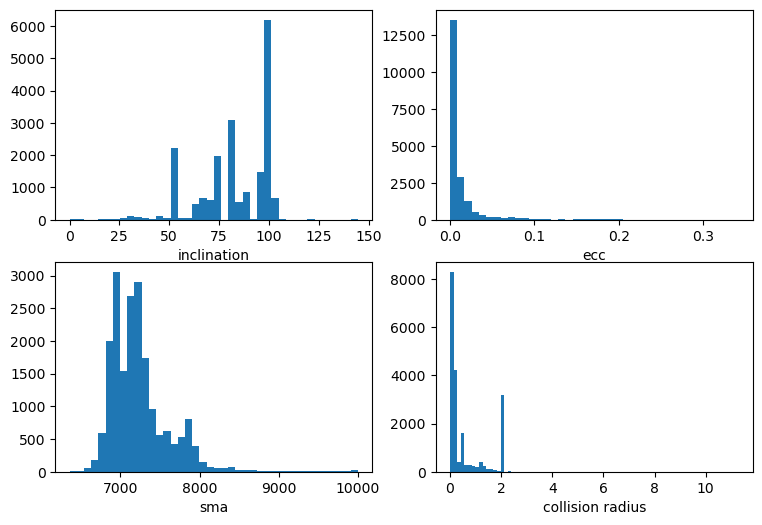

In [9]:
fig, axes = plt.subplots(2,2, figsize = (9,6))
axes[0,0].hist(incl, bins=40);
axes[0,0].set_xlabel("inclination");

axes[1,0].hist(smal, bins=40);
axes[1,0].set_xlabel("sma");

axes[0,1].hist(el, bins=40)
axes[0,1].set_xlabel("ecc");

axes[1,1].hist(reentry_radiusl, bins=80);
axes[1,1].set_xlabel("collision radius");

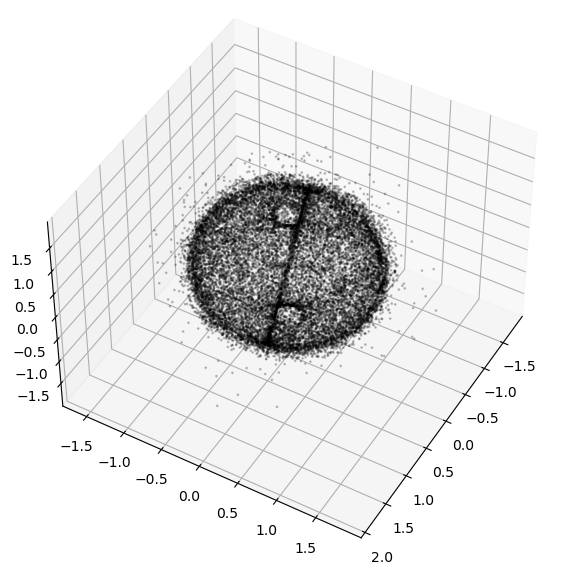

In [10]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
pos = np.array(r)
ax.scatter3D(pos[:,0]/pk.EARTH_RADIUS, pos[:,1]/pk.EARTH_RADIUS, pos[:,2]/pk.EARTH_RADIUS, alpha=0.2, s= 1, c='k')
ax.view_init(45,30)

In [11]:
with open("data/debris_simulation_ic.pk", "wb") as file:
    pkl.dump((r,v,reentry_radiusl,to_satcat_index,satcat,debris), file)